In [130]:
from rembg.bg import remove
import numpy as np
import io
from PIL import Image
from PIL import ImageFile
import cv2
from matplotlib import pyplot as plt

In [131]:
def display_image(image):
  # Opencv2 normally shows in BGR, we want RGB so convert before displaying
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  # Remove the graph ticks
  plt.xticks([]), plt.yticks([]) 
  # Show the image
  plt.show()

In [132]:
# IMAGE SETTINGS
input_path = 'banana.jpeg'
output_path = 'out.jpeg'

# IMAGE SIZE SETTINGS
TOTAL_IMAGE_SIZE = 350
IMAGE_BUFFER_SIZE = 50
CONTOUR_IMAGE_SIZE = TOTAL_IMAGE_SIZE - IMAGE_BUFFER_SIZE

# SVG SETTINGS
LINE_COLOR = '#FFE135'
BACKGROUND_COLOR = '#000000'
STROKE_WIDTH = 5

In [133]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

f = np.fromfile(input_path)
result = remove(f)
img = Image.open(io.BytesIO(result)).convert("RGB")
img.save(output_path)

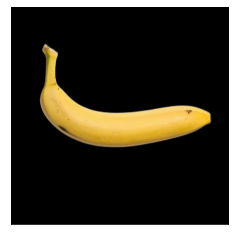

In [134]:
image = cv2.imread(output_path)
display_image(image)

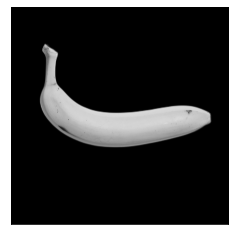

In [135]:
# Turn the image into greyscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
display_image(gray_image)

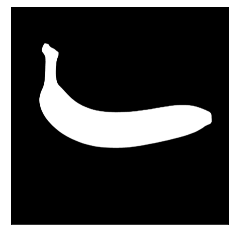

In [136]:
ret, threshold_image = cv2.threshold(gray_image, 5, 255, cv2.THRESH_BINARY)
display_image(threshold_image)

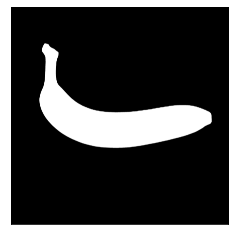

In [137]:
# Kernel used for erosion
kernal_value = 2
kernel = np.ones((kernal_value, kernal_value), np.uint8) 

# Refine edges
erosion_image = cv2.erode(threshold_image, kernel, iterations = 1)

display_image(erosion_image)

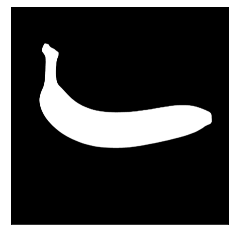

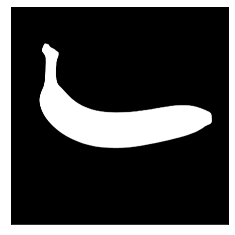

In [138]:
# Open the image (erosion followed by dilation) to remove noise
opening_image = cv2.morphologyEx(erosion_image, cv2.MORPH_OPEN, kernel)
display_image(opening_image)

# Close the image (dilation followed by erosion) to close holes
closing_image = cv2.morphologyEx(opening_image, cv2.MORPH_CLOSE, kernel)
display_image(closing_image)

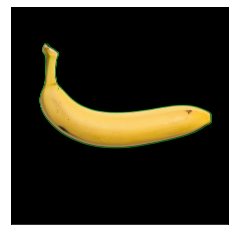

In [139]:
# Find the contours
contours, hierarchy = cv2.findContours(closing_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

max_contour = max(contours, key=cv2.contourArea)
contour_image = cv2.drawContours(image, [max_contour], 0, (0, 255, 0), 5, maxLevel = 0)
display_image(image)

In [140]:
# Create a bounding rectangle to see the "true" size of the contour
x,y,w,h = cv2.boundingRect(max_contour)

# Determine the longest side so that we scale that down the max
largest_side = w if w > h else h

# Get the scale factor that would lead to the desired contour image size (image size minus some buffer room)
scale = (CONTOUR_IMAGE_SIZE / largest_side) if largest_side > CONTOUR_IMAGE_SIZE else (largest_side / CONTOUR_IMAGE_SIZE)

In [141]:
moment = cv2.moments(max_contour)
center_x = int(moment["m10"] / moment["m00"])
center_y = int(moment["m01"] / moment["m00"])

center_x = int(center_x * scale)
print(center_x)
center_y = int(center_y * scale)
print(center_y)


179
194


In [142]:
hexagon_pattern = f'''
  <defs>
    <pattern id="hexagon_pattern" width="52.290799" height="45.285135" patternUnits="userSpaceOnUse">
      <path transform="matrix(3.7795 0 0 3.7795 -198.38 231.25)" d="m69.782-45.208 3.4588-1.997v-3.9939l-3.4588-1.9969-3.4588 1.9969 6e-6 3.9939zm-6.9176 0 3.4588-1.997v-3.9939l-3.4588-1.9969-3.4588 1.9969 5e-6 3.9939zm-6.9176 0 3.4588-1.997v-3.9939l-3.4588-1.9969-3.4588 1.9969 6e-6 3.9939zm-6.9176 0 3.4588-1.997v-3.9939l-3.4588-1.9969-3.4588 1.9969 5e-6 3.9939zm17.294-5.9908 3.4588-1.997v-3.9939l-3.4588-1.9969-3.4588 1.9969 6e-6 3.9939zm-6.9176 0 3.4588-1.997v-3.9939l-3.4588-1.9969-3.4588 1.9969 5e-6 3.9939zm-6.9176 0 3.4588-1.997v-3.9939l-3.4588-1.9969-3.4588 1.9969 6e-6 3.9939zm-6.9176 0 3.4588-1.997v-3.9939l-3.4588-1.9969m24.212 1.997 3.4588-1.997v-3.9939l-3.4588-1.9969-3.4588 1.9969 6e-6 3.9939zm-6.9176 0 3.4588-1.997v-3.9939l-3.4588-1.9969-3.4588 1.9969 5e-6 3.9939zm-6.9176 0 3.4588-1.997v-3.9939l-3.4588-1.9969-3.4588 1.9969 6e-6 3.9939zm-6.9176 0 3.4588-1.997v-3.9939l-3.4588-1.9969-3.4588 1.9969 5e-6 3.9939z" clip-path="url(#clipPath6435)" fill="none" stroke="{LINE_COLOR}" stroke-width="1.3229"/>
    </pattern>
  </defs>
'''

In [149]:
# Make SVG the size of the image we want
f = open('path.svg', 'w+')
f.write(f'<svg width="{TOTAL_IMAGE_SIZE}" height="{TOTAL_IMAGE_SIZE}" xmlns="http://www.w3.org/2000/svg">')

f.write(hexagon_pattern)

# Draw background
f.write(f'<rect x="0" y="0" width="{TOTAL_IMAGE_SIZE}" height="{TOTAL_IMAGE_SIZE}" fill="{BACKGROUND_COLOR}" />')

# Draw contour
f.write(f'<path stroke="{LINE_COLOR}" stroke-linejoin="round" stroke-width="{STROKE_WIDTH}" fill="url(#hexagon_pattern)" d="M')
for point in max_contour:
  x, y = point[0]

  # Scale the coordinates so the contour fits in the image size we defined
  x = x * scale
  y = y * scale

  # Translate the coordinates so that the contour is centered
  x = x - (center_x - int(TOTAL_IMAGE_SIZE / 2)) - 20
  y = y - (center_y - int(TOTAL_IMAGE_SIZE / 2)) + 20

  # Write the point to the SVG
  f.write(f'{round(x, 2)} {round(y, 2)} ')

# Complete and close path
f.write('Z" />')

# Complete and write SVG to file
f.write('</svg>')
f.close()